### TO DO:
(Problem statement)
(Describe the real-world phenomenon you are studying. Explain why the topic is important,
relevant, or interesting.)
(Uygar)

### TO DO:
(Data description)
Provide a brief description of your dataset, including the data source. 
(Uygar)

### Importing necessary libraries:

In [120]:
import pandas as pd 
import os 
import pymc as pm 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Data preprocessing

### Load the data and put them into data dictionary 

In [121]:
# Data path
data_path = os.path.join(os.getcwd(), '..', 'Data')

# Load the data
life_expectancy = pd.read_csv(os.path.join(data_path, 'estat_demo_mlexpec_en.csv'))
material_deprivation_rate = pd.read_csv(os.path.join(data_path, 'estat_ilc_mdsd04_filtered_en.csv'))
median_and_mean_group_income = pd.read_csv(os.path.join(data_path, 'estat_ilc_di15_filtered_en.csv'))
low_work_intensity_households = pd.read_csv(os.path.join(data_path, 'estat_ilc_lvhl16n_filtered_en.csv'))
real_gdp = pd.read_csv(os.path.join(data_path, 'estat_tipsna40_en.csv'))
population_data = pd.read_csv(os.path.join(data_path, 'estat_demo_pjanbroad_filtered_en.csv'))


# Dataframes dictionary 
dataframes_dict = {
    'life_expectancy': life_expectancy,
    'material_deprivation_rate': material_deprivation_rate,
    'median_and_mean_group_income': median_and_mean_group_income,
    'low_work_intensity_households': low_work_intensity_households,
    'real_gdp': real_gdp,
    'population_data': population_data
}


### Include only EU data and set data collection window to 2004 - 2023
GDP data is not older than 2003, therefore we use a data collection window of 2004 - 2023. For some datasets we don't have data from 2024.

In [122]:
# Include only EU data and set data collection window
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany',
       'Denmark','Estonia',
       'Greece', 'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy',
       'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands',
       'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia']

for key, df in dataframes_dict.items():
    dataframes_dict[key] = df[df['Geopolitical entity (reporting)'].isin(eu_countries)].reset_index(drop=True)
for key, df in dataframes_dict.items():
    dataframes_dict[key] = df.loc[(df['TIME_PERIOD'] >= 2004) & (df['TIME_PERIOD'] < 2024)].reset_index(drop=True)


### Filter data for "Less than one year" age group
This data represents the average life expectancy.

In [123]:
# Filter life expectancies for newborns
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].loc[dataframes_dict['life_expectancy']['age'] == 'Y_LT1'].reset_index(drop=True)

# Filter PPS currency
Median and mean data are available in three formats Euro, regional currency and PPS (Purchasing Power Standrad), we decide to use PPS because it adjusts for price level differences across regions, providing a more accurate basis for cross-country comparisons.

In [124]:
# Filter PPS (Purchasing Power Standard) currency 
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].loc[dataframes_dict['median_and_mean_group_income']['unit'] == 'PPS'].reset_index(drop=True)


### Generalize mean and median data 
Since mean and median values in our dataset are segmented by age groups, we gather corresponding population data and compute weighted averages. This allows us to estimate overall population-level statistics for our analysis. We also remove unnecessary columns. 

In [125]:
# Generalize mean and median data
# Filter age groups present in the data
age_groups = ['From 18 to 64 years', '65 years or over']
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'][dataframes_dict['median_and_mean_group_income']['Age class'].isin(age_groups)].reset_index(drop=True)

# Remove unnecessary columns
for key, df in dataframes_dict.items():
    dataframes_dict[key] = df.drop(columns=['STRUCTURE', 'STRUCTURE_NAME', 'STRUCTURE_ID', 'Confidentiality status (flag)', 'CONF_STATUS', 'Observation status (Flag) V2 structure', 'unit', 'Observation value', 'Time', 'geo', 'age', 'Sex',
                                            'Country of citizenship', 'citizen', 'Unit of measure', 'Income and living conditions indicator', 'freq', 'Time frequency', 'OBS_FLAG', 'National accounts indicator (ESA 2010)', 'na_item', 'c_birth', 'Country/region of birth'], errors='ignore')
    
    # Because the income date is available only by population, we need to merge it with population data to be able to combine the date for the whole population
dataframes_dict['population_data'].rename(columns={'OBS_VALUE': 'population'}, inplace=True)
dataframes_dict['population_data'].replace({'Age class': {'From 15 to 64 years': 'From 18 to 64 years'}}, inplace=True)
dataframes_dict['population_data'] = dataframes_dict['population_data'].loc[dataframes_dict['population_data']['Age class'] != 'Less than 15 years'].reset_index(drop=True)

dataframes_dict['median_and_mean_group_income'] = pd.merge(dataframes_dict['median_and_mean_group_income'],
                  dataframes_dict['population_data'],
                  on=['sex','Geopolitical entity (reporting)', 'TIME_PERIOD', 'Age class'],
                  how='left') 

# We group the data to calculate the weighted average of OBS_VALUE by population for each group defined
group_cols = ['sex', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'indic_il']

def weighted_average(group_df):
    weighted_sum = (group_df['OBS_VALUE'] * group_df['population']).sum()
    total_population = group_df['population'].sum()
    
    if total_population > 0:
        weighted_avg = weighted_sum / total_population
    else:
        weighted_avg = 0 
    
    return pd.Series({
        'OBS_VALUE': weighted_avg
    })

# Transform median and mean into seperate columns
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].groupby(group_cols).apply(weighted_average).reset_index()
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].drop(columns='Age class')
dataframes_dict['material_deprivation_rate'] = dataframes_dict['material_deprivation_rate'].drop(columns='Age class')
dataframes_dict['low_work_intensity_households'] = dataframes_dict['low_work_intensity_households'].drop(columns='Age class')

dataframes_dict['median_and_mean_group_income']['indic_il']
dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].pivot(index=[col for col in dataframes_dict['median_and_mean_group_income'].columns if col not in ['indic_il', 'OBS_VALUE']], columns='indic_il', values='OBS_VALUE').reset_index()


/var/folders/y4/lhggv2xd4_g7wl5ry_nch6q40000gn/T/ipykernel_36350/313758494.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataframes_dict['median_and_mean_group_income'] = dataframes_dict['median_and_mean_group_income'].groupby(group_cols).apply(weighted_average).reset_index()


# Rename columns

In [126]:
# Rename columns 
dataframes_dict['real_gdp'] = dataframes_dict['real_gdp'].rename(columns={'OBS_VALUE': 'real_gdp'})
dataframes_dict['low_work_intensity_households'] = dataframes_dict['low_work_intensity_households'].rename(columns={'OBS_VALUE': 'people_in_low_work_intensity_household_perc'})
dataframes_dict['material_deprivation_rate'] = dataframes_dict['material_deprivation_rate'].rename(columns={'OBS_VALUE': 'material_deprivation_rate_perc'})

### Create columns for GDP, mean and median 5 and 10 years later
We limit the TIME_PERIOD column to values from 2014 to 2023. However, we retain earlier data to compute additional columns for GDP, mean, and median income from 5 and 10 years prior. Data on material and social deprivation rates, as well as the share of people living in low work intensity households, is only available from 2014 onward and is used as-is.

In [127]:
# Limit life expectancy to 2014 
dataframes_dict['life_expectancy'] = dataframes_dict['life_expectancy'].loc[dataframes_dict['life_expectancy']['TIME_PERIOD'] >= 2014].reset_index(drop=True)

# Merge gdp with median and mean
real_gdp_med_mean = pd.merge(dataframes_dict['real_gdp'], dataframes_dict['median_and_mean_group_income'], on=['Geopolitical entity (reporting)', 'TIME_PERIOD'])

# Prepare GDP data for merging by creating shifted year columns
real_gdp_med_mean['TIME_PERIOD_plus_5'] = real_gdp_med_mean['TIME_PERIOD'] + 5
real_gdp_med_mean['TIME_PERIOD_plus_10'] = real_gdp_med_mean['TIME_PERIOD'] + 10

# Merge life expectancy with current year GDP
df_merged = pd.merge(dataframes_dict['life_expectancy'], real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_current', 'MED_E': 'MED_E_current', 'MEI_E': 'MEI_E_current'}, inplace=True)

# Merge life expectancy with GDP from 5 years before
df_merged = pd.merge(df_merged, real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_5', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_5', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_minus_5', 'MED_E': 'MED_E_minus_5', 'MEI_E': 'MEI_E_minus_5'}, inplace=True)

# Merge life expectancy with GDP from 10 years before
df_merged = pd.merge(df_merged, real_gdp_med_mean[['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_10', 'real_gdp', 'MED_E', 'MEI_E', 'sex']], how='left', left_on=['Geopolitical entity (reporting)', 'TIME_PERIOD', 'sex'], right_on=['Geopolitical entity (reporting)', 'TIME_PERIOD_plus_10', 'sex'])
df_merged.rename(columns={'real_gdp': 'real_gdp_minus_10', 'MED_E': 'MED_E_minus_10', 'MEI_E': 'MEI_E_minus_10'}, inplace=True)

# Cleanup unnecessary columns
df_merged.drop(columns=['TIME_PERIOD_plus_5', 'TIME_PERIOD_plus_10'], inplace=True)



### Merge material and social deprivation rate, and percentage of people living in low workload households

In [60]:
df_full = pd.merge(df_merged, dataframes_dict['low_work_intensity_households'], on=['TIME_PERIOD', 'sex', 'Geopolitical entity (reporting)'])
df_full = pd.merge(df_full, dataframes_dict['material_deprivation_rate'], on=['sex', 'TIME_PERIOD', 'Geopolitical entity (reporting)'])
df_full.head()

,sex,Geopolitical entity (reporting),TIME_PERIOD,OBS_VALUE,real_gdp_current,MED_E_current,MEI_E_current,real_gdp_minus_5,MED_E_minus_5,MEI_E_minus_5,real_gdp_minus_10,MED_E_minus_10,MEI_E_minus_10,people_in_low_work_intensity_household_perc,material_deprivation_rate_perc
0,F,Austria,2015,83.7,39640,23263.169051,25342.505855,38800.0,20206.403705,22544.439063,36950.0,17601.980989,19614.340744,4.4,5.9
1,F,Austria,2016,84.1,39970,24605.250521,26527.179513,39800.0,21228.830471,23461.591105,37970.0,17802.543685,19607.809630,5.3,4.9
2,F,Austria,2017,84.0,40620,24844.221020,27311.593112,39870.0,21636.216198,23801.369122,39270.0,18416.722715,20309.654523,4.9,5.0
3,F,Austria,2018,84.1,41430,24443.071028,26600.126648,39540.0,21898.770604,24150.041558,39710.0,19541.957659,21731.722816,4.7,4.2
4,F,Austria,2019,84.2,41970,25082.305739,27650.039982,39520.0,23041.372948,25606.672200,38200.0,20036.049266,22141.737160,4.7,4.5


### Add mean and median difference, and relative difference

In [67]:
df_full['mean-median'] = df_full['MEI_E_current'] - df_full['MED_E_current']
df_full['qoutient'] = (df_full['MEI_E_current'] - df_full['MED_E_current']) / df_full['MED_E_current']
df_full = df_full.dropna()


### Split data by sex

In [69]:
women = df_full.loc[df_full['sex'] == 'F'].reset_index(drop=True)
men = df_full.loc[df_full['sex'] == 'M'].reset_index(drop=True)
total = df_full.loc[df_full['sex'] == 'T'].reset_index(drop=True)


array(['T'], dtype=object)

### Plot life expectancy over time by sex

/var/folders/y4/lhggv2xd4_g7wl5ry_nch6q40000gn/T/ipykernel_36350/1400342844.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_cleaned, x='year', y='life_expectancy', hue='sex', estimator='mean', ci=None)


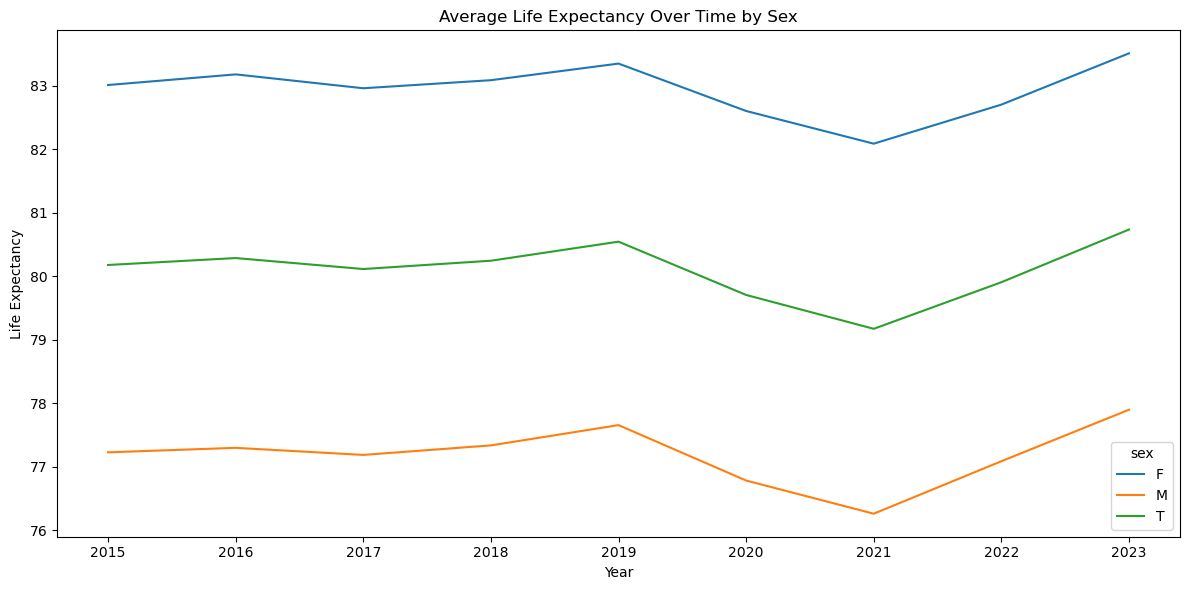

In [73]:
# Rename columns for easier plotting
df_cleaned = df_full.rename(columns={
    'Geopolitical entity (reporting)': 'country',
    'sex': 'sex',
    'TIME_PERIOD': 'year',
    'OBS_VALUE': 'life_expectancy'
})

# Plot: Life expectancy over time by sex
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x='year', y='life_expectancy', hue='sex', estimator='mean', ci=None)
plt.title("Average Life Expectancy Over Time by Sex")
plt.ylabel("Life Expectancy")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


### Compute correlation matrices

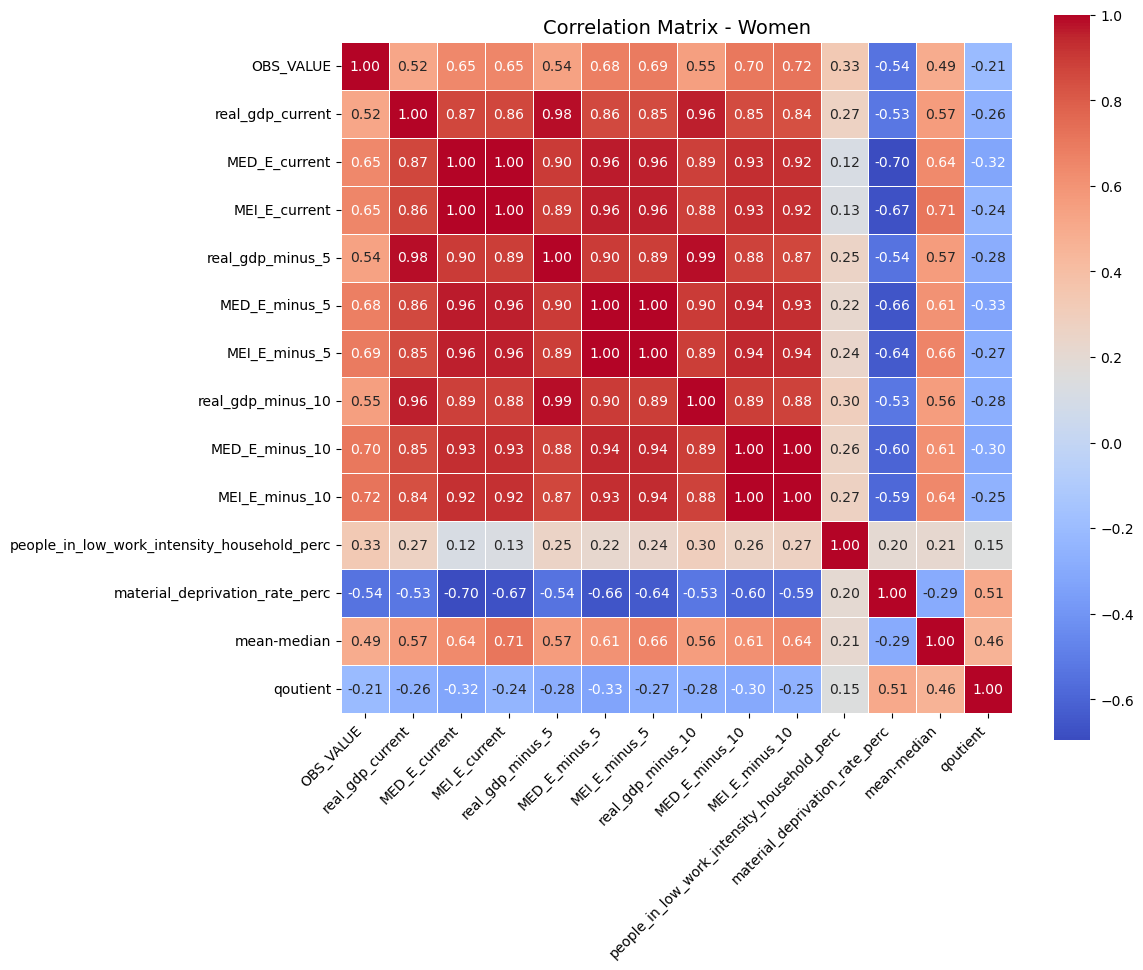

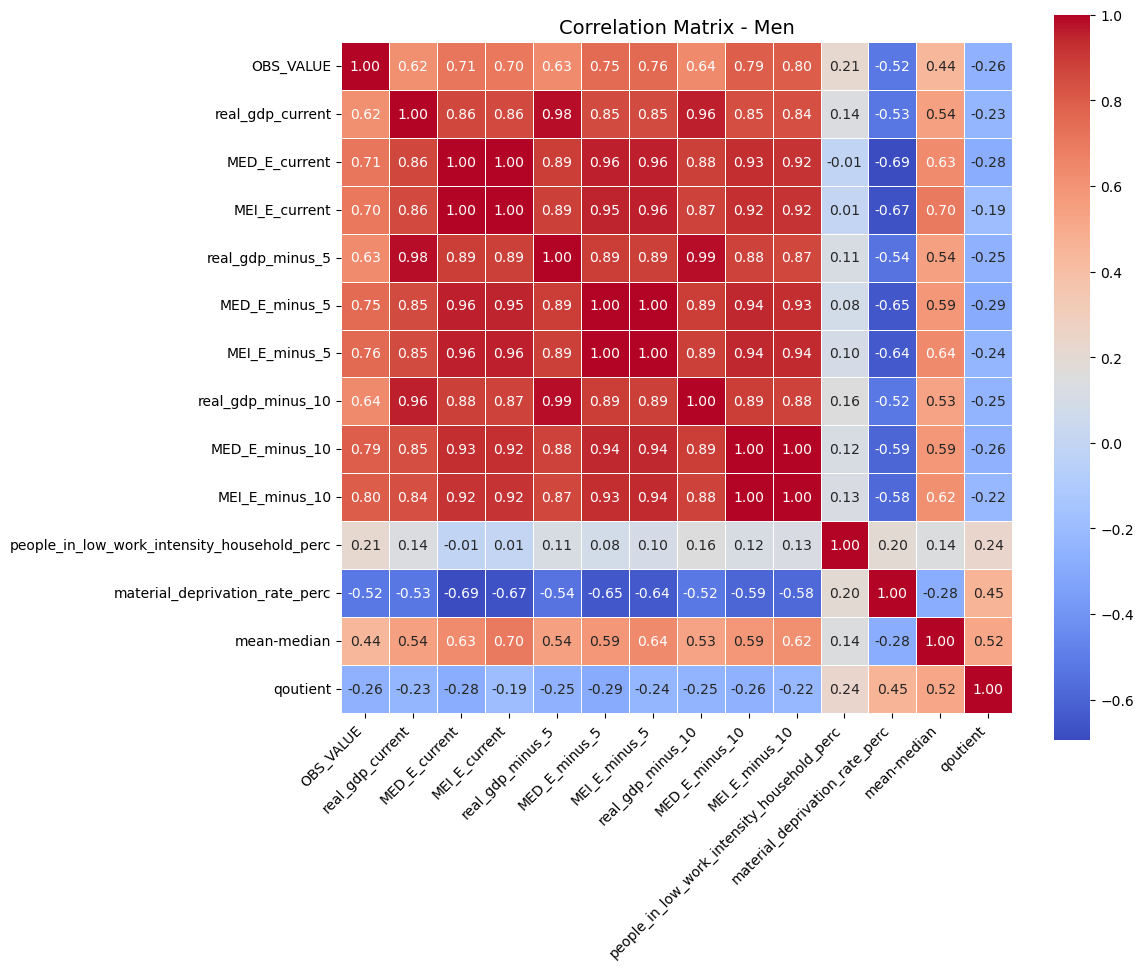

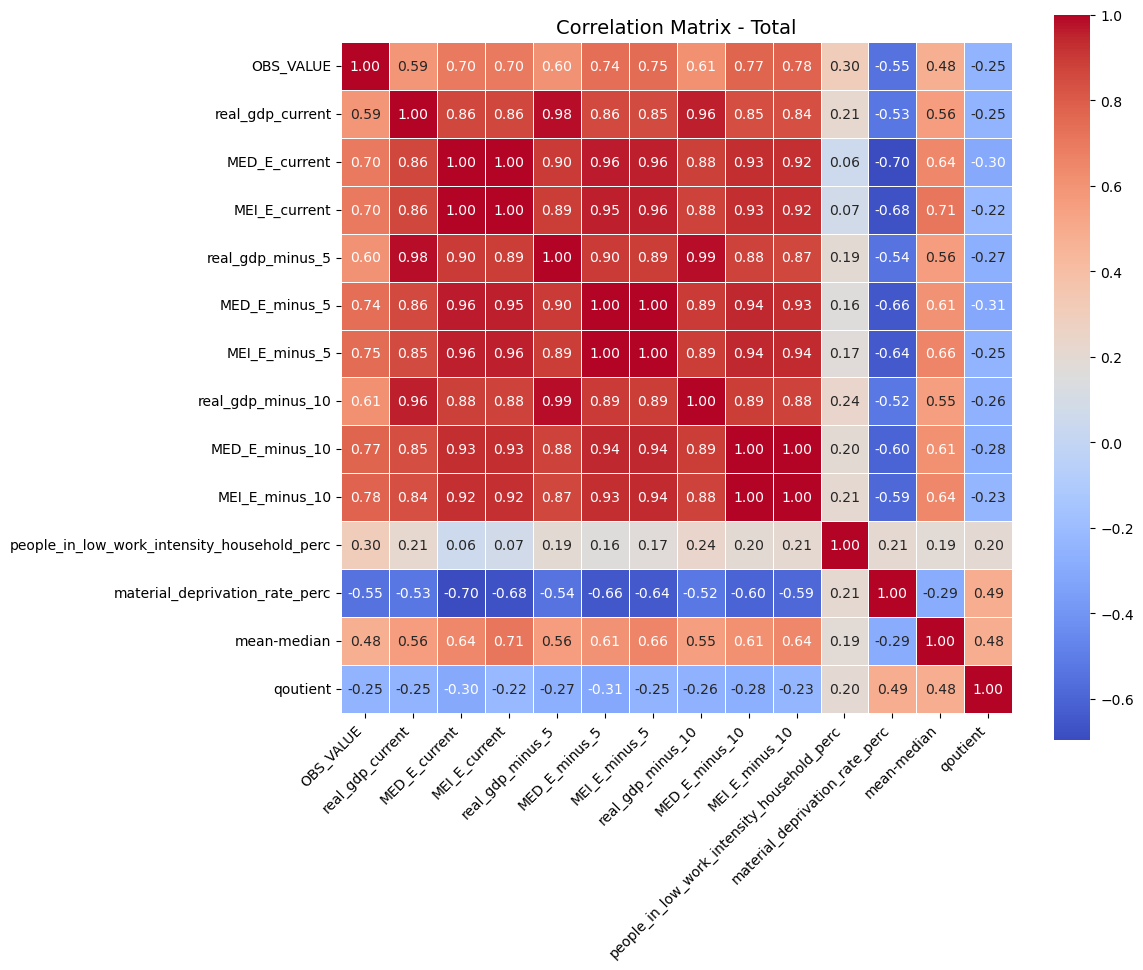

In [63]:
# Assuming 'df_full' already has the necessary columns created:
df_full['mean-median'] = df_full['MEI_E_current'] - df_full['MED_E_current']
df_full['qoutient'] = (df_full['MEI_E_current'] - df_full['MED_E_current']) / df_full['MED_E_current']

# Define correlation columns
corr_cols = [
    'OBS_VALUE', 'real_gdp_current', 'MED_E_current', 'MEI_E_current',
    'real_gdp_minus_5', 'MED_E_minus_5', 'MEI_E_minus_5',
    'real_gdp_minus_10', 'MED_E_minus_10', 'MEI_E_minus_10',
    'people_in_low_work_intensity_household_perc',
    'material_deprivation_rate_perc', 'mean-median', 'qoutient'
]

# Split by sex
women = df_full[df_full['sex'] == 'F'].reset_index(drop=True)
men = df_full[df_full['sex'] == 'M'].reset_index(drop=True)
total = df_full[df_full['sex'] == 'T'].reset_index(drop=True)

# Compute correlation matrices
corr_matrix_women = women[corr_cols].corr()
corr_matrix_men = men[corr_cols].corr()
corr_matrix_total = total[corr_cols].corr()

# Plotting function
def plot_corr_matrix(corr_matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        cbar=True, 
        square=True, 
        linewidths=0.5
    )
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot each
plot_corr_matrix(corr_matrix_women, "Correlation Matrix - Women")
plot_corr_matrix(corr_matrix_men, "Correlation Matrix - Men")
plot_corr_matrix(corr_matrix_total, "Correlation Matrix - Total")


### Calculate VIF factor
We calculate VIF factor between our potential independent variables to check for multicolinearity.

In [81]:
# Assuming your DataFrame is called df
cols = [
    'real_gdp_current',
    'people_in_low_work_intensity_household_perc',
    'material_deprivation_rate_perc', 'qoutient',
]

sexes = [total, women, men]
for sex in sexes:
    # Subset the DataFrame
    X = sex[cols].copy()

    # Optional: scale data to make VIF more stable numerically
    X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=cols)

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_scaled.columns
    vif_data['VIF'] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

    print(vif_data.sort_values('VIF', ascending=False))

                                       feature       VIF
2               material_deprivation_rate_perc  1.882005
0                             real_gdp_current  1.638098
3                                     qoutient  1.328289
1  people_in_low_work_intensity_household_perc  1.248829
                                       feature       VIF
2               material_deprivation_rate_perc  1.997522
0                             real_gdp_current  1.744609
3                                     qoutient  1.347629
1  people_in_low_work_intensity_household_perc  1.317811
                                       feature       VIF
2               material_deprivation_rate_perc  1.755837
0                             real_gdp_current  1.519076
3                                     qoutient  1.299054
1  people_in_low_work_intensity_household_perc  1.172229


In [129]:
# Standardize predictors
features = ['real_gdp_current', 'qoutient', 'material_deprivation_rate_perc', 'people_in_low_work_intensity_household_perc']
X = total[features]
X_scaled = StandardScaler().fit_transform(X)

# Convert to a named dict for clarity in model
X_scaled = pd.DataFrame(X_scaled, columns=['gdp', 'quotient', 'deprivation', 'work_rate'])

# Target variable
y = total['OBS_VALUE']

# Model with informative priors
with pm.Model() as model_info:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=1, sigma=0.5)
    beta_quotient = pm.Normal('beta_quotient', mu=1, sigma=0.5)
    beta_deprivation = pm.Normal('beta_deprivation', mu=-1, sigma=0.5)
    beta_work_rate = pm.Normal('beta_work_rate', mu=-1, sigma=0.5)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear model
    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample
    trace_info = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Model with non informative prior 
with pm.Model() as model_noninfo:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_gdp = pm.Normal('beta_gdp', mu=0, sigma=10)
    beta_quotient = pm.Normal('beta_quotient', mu=0, sigma=10)
    beta_deprivation = pm.Normal('beta_deprivation', mu=0, sigma=10)
    beta_work_rate = pm.Normal('beta_work_rate', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    mu = (
        alpha
        + beta_gdp * X_scaled['gdp']
        + beta_quotient * X_scaled['quotient']
        + beta_deprivation * X_scaled['deprivation']
        + beta_work_rate * X_scaled['work_rate']
    )

    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    trace_noninfo = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_gdp, beta_quotient, beta_deprivation, beta_work_rate, sigma]


/opt/homebrew/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


### Informative prior

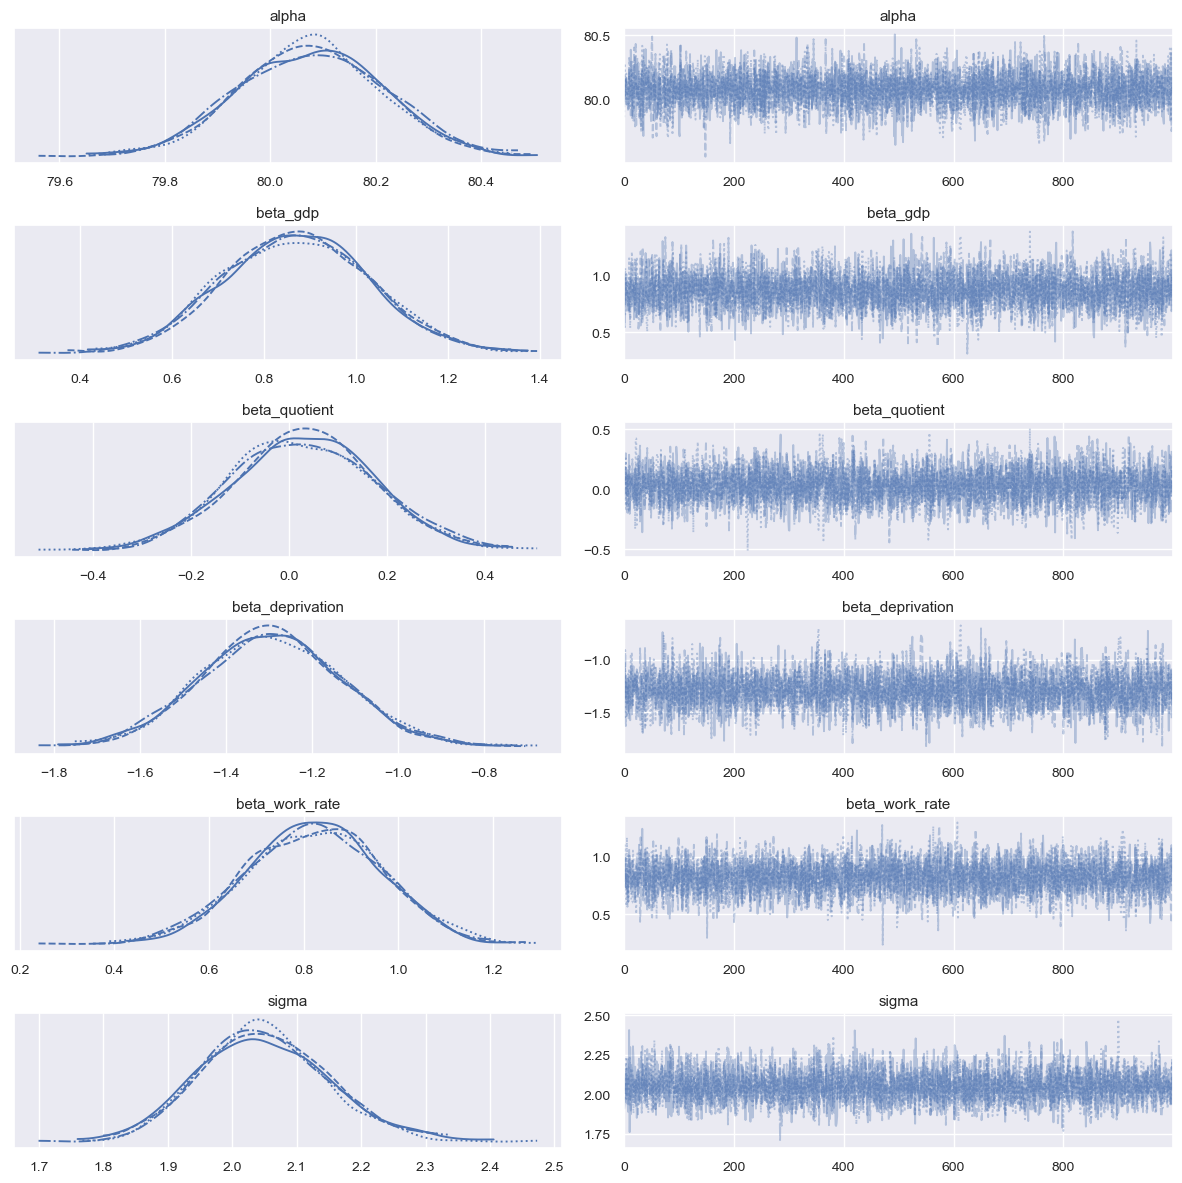

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             80.077  0.135  79.815   80.322      0.002    0.002   
beta_gdp           0.872  0.158   0.586    1.174      0.002    0.002   
beta_quotient      0.030  0.144  -0.240    0.302      0.002    0.002   
beta_deprivation  -1.293  0.167  -1.609   -0.979      0.003    0.003   
beta_work_rate     0.822  0.141   0.555    1.080      0.002    0.002   
sigma              2.050  0.098   1.870    2.236      0.001    0.002   

                  ess_bulk  ess_tail  r_hat  
alpha               5262.0    3084.0    1.0  
beta_gdp            4515.0    3296.0    1.0  
beta_quotient       5496.0    2843.0    1.0  
beta_deprivation    4265.0    2960.0    1.0  
beta_work_rate      4330.0    3327.0    1.0  
sigma               4663.0    2745.0    1.0  


In [119]:
# Trace plot for informative priors
az.plot_trace(trace_info, compact=True)
plt.tight_layout()
plt.show()

# Summary for informative priors 
info_summary = az.summary(trace_info)
# Pretty print with rounded decimals
print(info_summary)


### Non infromative prior

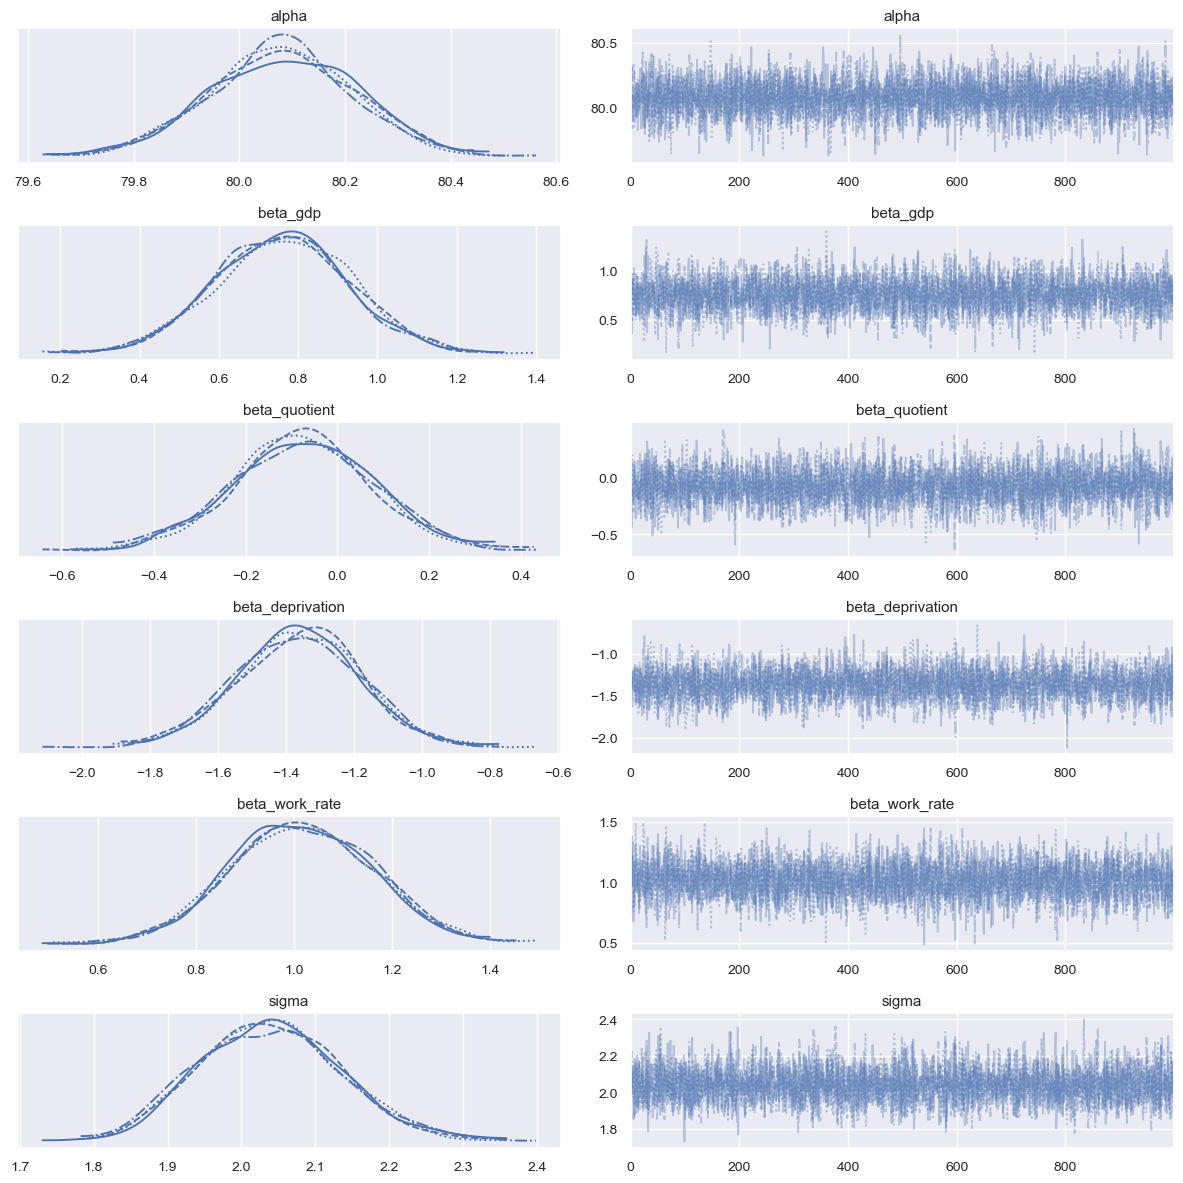

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha             80.079  0.137  79.829   80.342      0.002    0.002   
beta_gdp           0.759  0.168   0.443    1.077      0.003    0.003   
beta_quotient     -0.074  0.152  -0.371    0.208      0.002    0.002   
beta_deprivation  -1.361  0.181  -1.708   -1.026      0.003    0.003   
beta_work_rate     1.015  0.146   0.733    1.280      0.002    0.002   
sigma              2.040  0.096   1.861    2.213      0.001    0.002   

                  ess_bulk  ess_tail  r_hat  
alpha               5644.0    2793.0    1.0  
beta_gdp            3966.0    3173.0    1.0  
beta_quotient       4467.0    2883.0    1.0  
beta_deprivation    3844.0    3112.0    1.0  
beta_work_rate      4402.0    3347.0    1.0  
sigma               4935.0    2659.0    1.0  


In [130]:
# Trace plot for non-informative priors 
az.plot_trace(trace_noninfo, compact=True)
plt.tight_layout()
plt.show()

# Summary for non-informative priors 
noninfo_summary = az.summary(trace_noninfo)
print(noninfo_summary.round(3))

(Uygar) 
Below are the requirements from Damian, we prepared two bayesian linear reggressions, one with informative prior and one with non-informative, please get familiar with above code and descriptions. As you can see we were experimenting with different columns, but at the end we decided to use few of them because of high correlations. Filip send you links to the data source, please write data description at the beginnig and state our problem. 
Please write the below requirement points. You need to comment model diagnostics provided in the summary tables for both models, and write summary. 
Thanks

3. Model Description (10 points)
Explain the model(s) you intend to use and justify your choice. Clearly define:
• The parametric form of your model
• The connection between the model and your data
• The likelihood function and prior(s)
You must either:
• Use at least two different priors (e.g., one weakly informative), or
• Use two different models (distinct likelihoods)
Provide either a derivation of the posterior or describe the method used to approximate it (e.g.,
MCMC, variational inference, etc.).
4. Model Diagnostics (15 points)
Evaluate the assumptions of your model and, if applicable, assess MCMC convergence. Include
appropriate diagnostic plots and interpretation.
5. Results (15 points)
Summarize your posterior inferences. Relate your findings back to your research question. If
multiple models or priors were used, compare and contrast the results. Highlight any limitations
of your approach.